In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

## Function to load tweets along with their label and id
def load_data(path):
  return pd.read_csv(path)[["id","tweets","label"]]

In [2]:
## Load the preprocessed tweets
tweets=load_data("https://0f41bdd6-d0a9-458e-937c-838e849bb6f4.usrfiles.com/ugd/0f41bd_520705b60d3149cf990572133108dffc.csv")
test_tweets = pd.read_csv('https://0f41bdd6-d0a9-458e-937c-838e849bb6f4.usrfiles.com/ugd/0f41bd_8fcf459d1c1b4906a9e488335bdc9dec.csv')

Data Analysis

https://colab.research.google.com/drive/1DLoVMkGTGFtNh9nAFCq4ppe_4K8ETono?usp=sharing

In [3]:
import nltk
nltk.download('stopwords')
from sklearn import feature_extraction, model_selection, naive_bayes, pipeline, manifold, preprocessing

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [4]:
lst_stopwords = nltk.corpus.stopwords.words("english")

In [5]:
from nltk.tokenize import sent_tokenize, word_tokenize
nltk.download('punkt')
import nltk
nltk.download('averaged_perceptron_tagger')
def pos(text):
    pos=nltk.pos_tag(word_tokenize(text))
    pos=list(map(list,zip(*pos)))[1]
    return pos

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


In [6]:
X_train_tweets, X_test_tweets, y_train, y_test = train_test_split(tweets[['id','tweets']], tweets[['id','label']], test_size=0.2, shuffle=True)
## Function to get encoding given a tweet
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')
sid = SentimentIntensityAnalyzer()
def get_vader_score(sent):
    # Polarity score returns dictionary
    ss = sid.polarity_scores(sent)
    #return ss
    return np.argmax(list(ss.values())[:-1])
def get_encoding_per_tweet(tweet):
  encoding=[]
  tweet=tweet.lower()

  # TWEET RELATED TO EARTHQUAKE
  if "earthquake" in tweet:
    encoding.append(1)
  else:
    encoding.append(0)

  # TWEETS RELATED TO INJURIES AND DEATHS
  if "death" in tweet and "toll" in tweet or 'victim' in tweet or "injur" in tweets:
    encoding.append(1) # Can call another function in place of "0" which will give first encoding
  else:
    encoding.append(0) # Can call another function in place of "1" which will give second encoding
  encoding.append(get_vader_score(tweet))

  if "dozens" in tweet or "thousands" in tweet or  "hundreds" in tweet:
    encoding.append(1) # Can call another function in place of "0" which will give first encoding
  else:
    encoding.append(0) # Can call another function in place of "1" which will give second encoding

  #TWEETS RELATED TO MISSING OR MISPLACED PEOPLE
  if "miss" in tweet or "evacuat" in tweet or "displac" in tweet or "lost" in tweet or "relocat" in tweet :
    encoding.append(1) # Can call another function in place of "0" which will give first encoding
  else:
    encoding.append(0) # Can call another function in place of "1" which will give second encoding
  
  #TWEETS THAT TALK ABOUT FIRES AND TSUNAMI
  if "fire" in tweet or "tsunami" in tweet:
    encoding.append(1) # Can call another function in place of "0" which will give first encoding
  else:
    encoding.append(0) # Can call another function in place of "1" which will give second encoding
  
  return encoding


## Get Encodings for all tweets [train or test, whichever supplied]
def get_encoding_for_data(data):
  X=[]
  # Get encoding for each tweet in the data(set of tweets)
  for tweet_id,tweet in zip(data['id'],data['tweets']):
    X.append(get_encoding_per_tweet(tweet))
  return X

# feat_embedding=pd.DataFrame(get_encoding_for_data(X_train_tweets),columns=['a','b','c','d','e','f'])

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


/usr/local/lib/python3.7/dist-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


In [7]:

tweets['tweets'] = tweets['tweets'].apply(lambda x: str(x).lower())
test_tweets['tweets'] = test_tweets['tweets'].apply(lambda x:x.lower())

def remove_stopwords(tweet, stopwords_list):
  tweet = tweet.split()
  fin_list = []
  for word in tweet:
    if word not in stopwords_list:
      fin_list.append(word)
  
  updated_sent = " "
  updated_sent = updated_sent.join(fin_list)
  return updated_sent

def pos_selection(tweet):
  pos_list=pos(tweet)
  tweet = tweet.split()
  fin_list = []
  for tag,word in zip(pos_list,tweet):
    if "VB" in tag or "JJ" in tag or "RB" in tag or "NN" in tag:
      if "NNP" not in tag: 
        fin_list.append(word)
  
  updated_sent = " "
  updated_sent = updated_sent.join(fin_list)
  return updated_sent

tweets['tweets'] = tweets['tweets'].apply(lambda x: pos_selection(x))
# tweets['tweets'] = tweets['tweets'].apply(lambda x: remove_stopwords(x,lst_stopwords))
# test_tweets['tweets'] = test_tweets['tweets'].apply(lambda x: remove_stopwords(x,lst_stopwords))

In [8]:
## Split into train and test, 80:20 split used
X_train_tweets, X_test_tweets, y_train, y_test = train_test_split(tweets[['id','tweets']], tweets[['id','label']], test_size=0.2, shuffle=False)

In [9]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(min_df=2,max_df=0.5, ngram_range=(1,3))
model=tfidf.fit(X_train_tweets['tweets'])
features=model.transform(X_train_tweets['tweets'])
features_test=model.transform(X_test_tweets['tweets'])
x_train=features
x_test=features_test

x_new_test=model.transform(test_tweets['tweets'])
# print(model.transform(X_train_tweets['tweets']).shape)
# print(model.transform(X_test_tweets['tweets']).shape)

In [10]:
# REMOVING LOW VARIANCE FEATURES
from sklearn.feature_selection import VarianceThreshold
constant_filter = VarianceThreshold(threshold = 0.0002)
constant_filter.fit(x_train)
# feature_list = x_train
# print('Number of selected features: ' ,len(list(feature_list)),'\n')
# print('List of selected features: \n' ,list(feature_list))

VarianceThreshold(threshold=0.0002)

In [11]:
x_train_filter = constant_filter.transform(x_train)
x_test_filter = constant_filter.transform(x_test)
x_new_test_filter = constant_filter.transform(x_new_test)
x_train_filter.shape, x_test_filter.shape, x_train.shape,x_new_test_filter.shape

((13904, 622), (3476, 622), (13904, 26533), (1000, 622))

In [12]:
x_train_filter = pd.DataFrame(x_train_filter.toarray())
x_test_filter = pd.DataFrame(x_test_filter.toarray())
x_new_test_filter = pd.DataFrame(x_new_test_filter.toarray())

In [13]:
def get_correlation(data, threshold):
    corr_col = set()
    cormat = data.corr()
    for i in range(len(cormat.columns)):
        for j in range(i):
            if abs(cormat.iloc[i,j]) > threshold:
                colname = cormat.columns[i]
                corr_col.add(colname)
    return corr_col
corr_features = get_correlation(x_train_filter, 0.70)

In [14]:
x_train_uncorr = x_train_filter.drop(labels= corr_features, axis = 1)
x_test_uncorr = x_test_filter.drop(labels= corr_features, axis = 1)
x_new_test_uncorr = x_new_test_filter.drop(labels= corr_features, axis = 1)
x_train_uncorr = pd.DataFrame(x_train_uncorr)
x_test_uncorr = pd.DataFrame(x_test_uncorr)
x_new_test_uncorr = pd.DataFrame(x_new_test_uncorr)
x_train_uncorr.shape, x_test_uncorr.shape, x_new_test_uncorr.shape

((13904, 568), (3476, 568), (1000, 568))

In [15]:
x_train_uncorr=pd.concat([x_train_uncorr,pd.DataFrame(get_encoding_for_data(X_train_tweets),columns=['a','b','c','d','e','f'])],axis=1)
x_test_uncorr=pd.concat([x_test_uncorr,pd.DataFrame(get_encoding_for_data(X_test_tweets),columns=['a','b','c','d','e','f'])],axis=1)


In [16]:
## Train with SVM
from sklearn import svm
# Can be used to get a rough estimate of score, later we use grid search to find better parameters
clf = svm.SVC(cache_size=10000,class_weight="balanced")
# Fit over encodings and labels(binary labels) of the data
clf.fit(x_train_uncorr, y_train["label"]) 

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,


SVC(cache_size=10000, class_weight='balanced')

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,


              precision    recall  f1-score   support

           0     0.8030    0.9314    0.8624      1982
           1     0.8845    0.6968    0.7795      1494

    accuracy                         0.8306      3476
   macro avg     0.8437    0.8141    0.8209      3476
weighted avg     0.8380    0.8306    0.8268      3476

X-axis: Obtained Labels Y-axis: Actual Labels


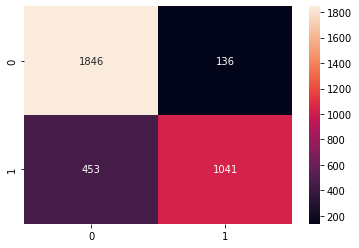

In [17]:
## Get predictions and obtain scores and confusion matrix
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

predictions= clf.predict(x_test_uncorr)
print(classification_report(y_test['label'], predictions,digits=4))
cf_matrix = confusion_matrix(y_test['label'], predictions)
sns.heatmap(cf_matrix, annot=True, fmt='g')
print("X-axis: Obtained Labels Y-axis: Actual Labels")

Try your own sentence

In [18]:
sentence="Waves of water killing people"
sentences=pd.DataFrame([sentence])
sentences = sentences.apply(lambda x: str(x).lower())
sentences = sentences.apply(lambda x: pos_selection(x))
features=model.transform(sentences)
filtered_sentence = constant_filter.transform(features)
sentence_uncorr = pd.DataFrame(filtered_sentence.toarray()).drop(labels= corr_features, axis = 1)
X=pd.concat([sentence_uncorr,pd.DataFrame([get_encoding_per_tweet(sentence)],columns=['a','b','c','d','e','f'])],axis=1)
if clf.predict(X)[0]==1:
  print("Critical Tweet")
else:
  print("Not a Critical Tweet")

Critical Tweet


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
